# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

## Подготовка данных

### Импорт

#### Библиотеки

In [7]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import re

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsClassifier

In [8]:
#подготовка данных и основные библиотеки
import pandas as pd
import numpy as np
import random

In [9]:
#кодирование классов и разделение выборки
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [10]:
#работа с моделью
from sklearn.linear_model import LinearRegression
from catboost import CatBoostRegressor

In [11]:
#Работа с метриками
import matplotlib.pyplot as plt  
import seaborn as sns 
from sklearn.metrics import mean_squared_error,  r2_score, mean_absolute_error

#### Генеральные переменные

In [12]:
RANDOM_STATE = 12345

### Описание данных

<b>Признаки</b>
<pre>
DateCrawled       — дата скачивания анкеты из базы
VehicleType       — тип автомобильного кузова
RegistrationYear  — год регистрации автомобиля
Gearbox           — тип коробки передач
Power             — мощность (л. с.)
Model             — модель автомобиля
Kilometer         — пробег (км)
RegistrationMonth — месяц регистрации автомобиля
FuelType          — тип топлива
Brand             — марка автомобиля
Repaired          — была машина в ремонте или нет
DateCreated       — дата создания анкеты
NumberOfPictures  — количество фотографий автомобиля
PostalCode        — почтовый индекс владельца анкеты (пользователя)
LastSeen          — дата последней активности пользователя
</pre>
<b>Целевой признак</b>
<pre>
Price             — цена (евро)
</pre>

<div style="border:solid #81d8e6 2px; padding: 10px">
    
Нам нужно выбрать параметры, которые не будут влиять на цену автомобиля. В этот список можно отнести
    
    - DateCrawled (так как это значение неинформативно для пользователей)
    - RegistrationMonth (месяц регистрации также неинформативен, нам скорее важен год)
    - PostalCode (это переменная-ключ, она не влияет на качество автомобиля)
    - LastSeen (активность пользователя не влияет на цену, которую он ставит на автомобиль)
    - DateCreated (тоже дата, которая непосредственно на цену автомобиля не влияет)

Остальные параметры важны для анализа.
</div>

### Загрузка данных и первичный анализ

In [24]:
try:
    data = pd.read_csv(r'C:\Users\Dmitri\Downloads\datasets\autos.csv')
except:
    data = pd.read_csv('/datasets/autos.csv.')

In [25]:
data.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [26]:
max(pd.to_datetime(data['DateCrawled']))

Timestamp('2016-04-07 14:36:58')

Актуальный год: 2016.

In [27]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

In [28]:
data.describe()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


<div style="border:solid #81d8e6 2px; padding: 10px">
Мы уже видим некоторые проблемы в данных:
    
    - есть пропущенные значения  
    - есть лишние, неинформативные столбцы 
    - нужно проверять на дубликаты
    - нужно проверять на выбросы
    
</div>

#### Важные функции

Функция создания графиков типа pie

In [29]:
def pie_plot(column=data.columns[0], binar=False, series=False, data=data, title=''):
    if series==False:
        fig1, ax1 = plt.subplots(figsize =(7, 7))
        colors = ("cornflowerblue","lightcoral", "springgreen", "bisque",
              "pink", "gold")
        ax1.pie(data[column].value_counts(), 
                labels=data[column].value_counts().index, 
                autopct='%1.1f%%', 
                shadow=True, 
                startangle=90, 
                colors=colors)
        patches, texts, auto = ax1.pie(data[column].value_counts(), 
                                       labels=data[column].value_counts().index, 
                                       shadow=True, 
                                       startangle=90, 
                                       autopct='%1.1f%%',
                                       colors=colors)
        plt.rcParams['font.size'] = 10
        plt.title(column)
    else:
        fig1, ax1 = plt.subplots(figsize =(7, 7))
        colors = ("cornflowerblue","lightcoral", "springgreen", "bisque",
              "pink", "gold")
        ax1.pie(data.value_counts(), 
                labels=data.value_counts().index, 
                autopct='%1.1f%%', 
                shadow=True, 
                startangle=90, 
                colors=colors)
        patches, texts, auto = ax1.pie(data.value_counts(), 
                                       labels=data.value_counts().index, 
                                       shadow=True, 
                                       startangle=90, 
                                       autopct='%1.1f%%',
                                       colors=colors)
        plt.rcParams['font.size'] = 10
        plt.title(title)

Функция создания графика интерквартильного размаха

In [30]:
def quant(column, data=data, figsize=(5,5), error=False, ylim=False, show=True):
    if error==False:
        q1 = np.percentile(data[column], 25)
        q3 = np.percentile(data[column], 75)
    else:
        q3 = data[column].describe()['75%'] 
        q1 = data[column].describe()['25%']
    iqr = q3 - q1
    new_data = data[(data[column]>(q1-1.5*iqr))&(data[column]<(q3+1.5*iqr))] 
    if ylim!=False:
        new_dataplot.set_ylim(ylim)
    if show == True:
        new_dataplot = new_data.boxplot(column=column, figsize=figsize)
        display()
    print(q1-1.5*iqr, q3+1.5*iqr)
    return new_data

### Работа с неинформативными признаками

In [31]:
data

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354364,2016-03-21 09:50:58,0,NaN,2005,manual,0,colt,150000,7,petrol,mitsubishi,yes,2016-03-21 00:00:00,0,2694,2016-03-21 10:42:49
354365,2016-03-14 17:48:27,2200,NaN,2005,NaN,0,NaN,20000,1,NaN,sonstige_autos,NaN,2016-03-14 00:00:00,0,39576,2016-04-06 00:46:52
354366,2016-03-05 19:56:21,1199,convertible,2000,auto,101,fortwo,125000,3,petrol,smart,no,2016-03-05 00:00:00,0,26135,2016-03-11 18:17:12
354367,2016-03-19 18:57:12,9200,bus,1996,manual,102,transporter,150000,3,gasoline,volkswagen,no,2016-03-19 00:00:00,0,87439,2016-04-07 07:15:26


In [32]:
data = data.drop(['DateCrawled', 'RegistrationMonth', 'PostalCode', 'LastSeen', 'DateCreated'], axis = 1)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 11 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   Price             354369 non-null  int64 
 1   VehicleType       316879 non-null  object
 2   RegistrationYear  354369 non-null  int64 
 3   Gearbox           334536 non-null  object
 4   Power             354369 non-null  int64 
 5   Model             334664 non-null  object
 6   Kilometer         354369 non-null  int64 
 7   FuelType          321474 non-null  object
 8   Brand             354369 non-null  object
 9   Repaired          283215 non-null  object
 10  NumberOfPictures  354369 non-null  int64 
dtypes: int64(5), object(6)
memory usage: 29.7+ MB


<div style="border:solid #81d8e6 2px; padding: 10px">
Мы удалили ненужные колонки, теперь можно переходить непосредственно к предобработке, чтобы не тратить время на лишние столбцы.
</div>

### Работа с пропусками

In [33]:
data.isna().sum()

Price                   0
VehicleType         37490
RegistrationYear        0
Gearbox             19833
Power                   0
Model               19705
Kilometer               0
FuelType            32895
Brand                   0
Repaired            71154
NumberOfPictures        0
dtype: int64

#### VehicleType

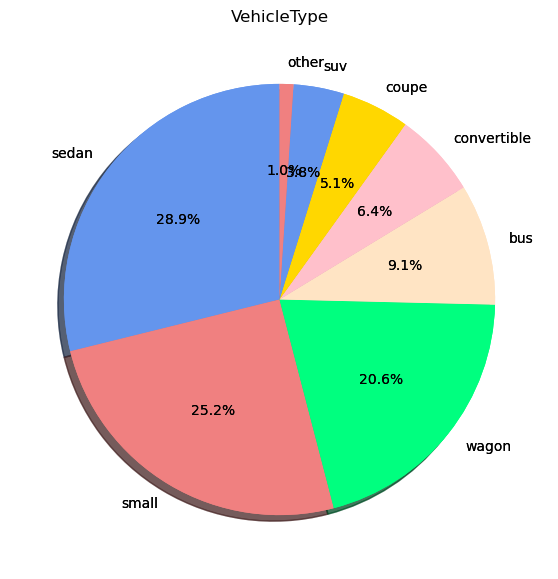

In [34]:
pie_plot('VehicleType')

In [35]:
data['VehicleType'].isna().sum()

37490

In [36]:
data['VehicleType'].fillna('uncpecified', inplace=True)
data['VehicleType'].value_counts()

sedan          91457
small          79831
wagon          65166
uncpecified    37490
bus            28775
convertible    20203
coupe          16163
suv            11996
other           3288
Name: VehicleType, dtype: int64

#### Gearbox             

manual    268251
auto       66285
Name: Gearbox, dtype: int64

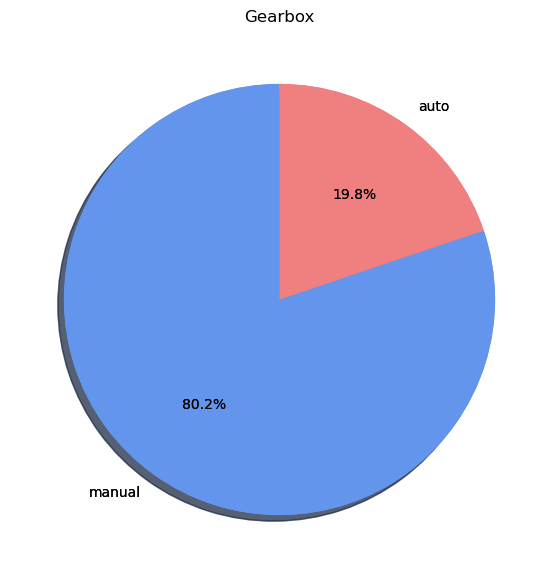

In [37]:
pie_plot('Gearbox')
data['Gearbox'].value_counts()

In [38]:
data['Gearbox'].isna().sum()

19833

In [39]:
data['Gearbox'].fillna('manual', inplace=True)

In [40]:
data['Gearbox'].isna().sum()
data['Gearbox'].value_counts()

manual    288084
auto       66285
Name: Gearbox, dtype: int64

#### Model               

In [41]:
data['Model'].value_counts()

golf                  29232
other                 24421
3er                   19761
polo                  13066
corsa                 12570
                      ...  
i3                        8
serie_3                   4
rangerover                4
range_rover_evoque        2
serie_1                   2
Name: Model, Length: 250, dtype: int64

In [42]:
data['Model'].isna().sum()

19705

In [43]:
data['Model'].fillna('uncpecified', inplace=True)
data['Model'].value_counts()

golf                  29232
other                 24421
3er                   19761
uncpecified           19705
polo                  13066
                      ...  
i3                        8
serie_3                   4
rangerover                4
range_rover_evoque        2
serie_1                   2
Name: Model, Length: 251, dtype: int64

#### FuelType            

In [44]:
#pie_plot('FuelType')

In [45]:
data['FuelType'].value_counts()

petrol      216352
gasoline     98720
lpg           5310
cng            565
hybrid         233
other          204
electric        90
Name: FuelType, dtype: int64

In [46]:
data['FuelType'].isna().sum()

32895

In [47]:
data['FuelType'].fillna('petrol', inplace=True)

In [48]:
data['FuelType'].isna().sum()

0

In [49]:
data['FuelType'].value_counts()

petrol      249247
gasoline     98720
lpg           5310
cng            565
hybrid         233
other          204
electric        90
Name: FuelType, dtype: int64

#### Repaired            

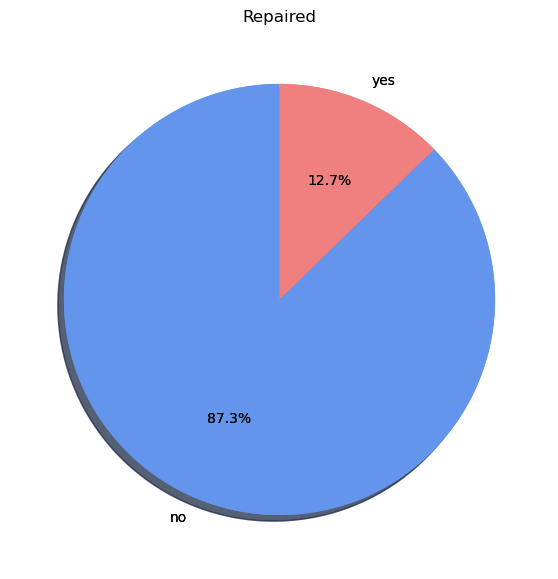

In [50]:
pie_plot('Repaired')

In [51]:
data['Repaired'].isna().sum()

71154

In [52]:
data['Repaired'].fillna('no', inplace=True)
data['Repaired'].isna().sum()

0

In [53]:
data.isna().sum()

Price               0
VehicleType         0
RegistrationYear    0
Gearbox             0
Power               0
Model               0
Kilometer           0
FuelType            0
Brand               0
Repaired            0
NumberOfPictures    0
dtype: int64

#### Мини-вывод и обоснование

<div style="border:solid #81d8e6 2px; padding: 10px">
Мы заполнили пропуски:
    
    - В столбце VehicleType (тип кузова) мы заменили неизвестные значения на 'uncpecified' (не указано), так как у нас 37000 пропусков, а следовательно добавление их к любому из уже существующих классов может привести к изменению распределения.
    - В столбце Gearbox мы заменили неизвестные значения на manual, потому что этих значений больше 80%, мы сравнили данные до замены и после. Соотношение значений изменилось не более, чем на 1,5%.
    - В столбце Model мы также заменили неизвестные значения на 'uncpecified' (не указано), так как у нас слишком большое количество пропусков и широкий список моделей.
    - В столбце FuelType мы заменили пропуски на petrol, так как это самое распространённое значение, а также самый популярный вид топлива. Скорее всего, если не вносились особые сведения о топливе, то используется самый популярный вариант - бензин.
    - В столбце Repaired мы заменили пропуски на no, так как скорее всего, если не вносились сведения о ремонте, его не было.
</div>

### Работа с дубликатами

In [54]:
data.duplicated().sum()

56547

In [55]:
data.drop_duplicates(inplace=True)
data.duplicated().sum()

0

<div style="border:solid #81d8e6 2px; padding: 10px">
Так как после удаления неинформативных столбцов появились данные с одинаковыми параметрами, мы их удалили для избежания переобучения модели.
</div>

### Работа с типами столбцов

In [56]:
data.head()

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired,NumberOfPictures
0,480,uncpecified,1993,manual,0,golf,150000,petrol,volkswagen,no,0
1,18300,coupe,2011,manual,190,uncpecified,125000,gasoline,audi,yes,0
2,9800,suv,2004,auto,163,grand,125000,gasoline,jeep,no,0
3,1500,small,2001,manual,75,golf,150000,petrol,volkswagen,no,0
4,3600,small,2008,manual,69,fabia,90000,gasoline,skoda,no,0


In [57]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 297822 entries, 0 to 354368
Data columns (total 11 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   Price             297822 non-null  int64 
 1   VehicleType       297822 non-null  object
 2   RegistrationYear  297822 non-null  int64 
 3   Gearbox           297822 non-null  object
 4   Power             297822 non-null  int64 
 5   Model             297822 non-null  object
 6   Kilometer         297822 non-null  int64 
 7   FuelType          297822 non-null  object
 8   Brand             297822 non-null  object
 9   Repaired          297822 non-null  object
 10  NumberOfPictures  297822 non-null  int64 
dtypes: int64(5), object(6)
memory usage: 27.3+ MB


<div style="border:solid #81d8e6 2px; padding: 10px">
Cтолбцы в корректировке не нуждаются.
</div>

### Работа с выбросами

In [58]:
data.describe()

,Price,RegistrationYear,Power,Kilometer,NumberOfPictures
count,297822.000000,297822.000000,297822.000000,297822.000000,297822.0
mean,4563.171589,2004.435670,111.961027,126680.114296,0.0
std,4593.363691,94.212298,204.443324,38852.069958,0.0
min,0.000000,1000.000000,0.000000,5000.000000,0.0
25%,1111.000000,1999.000000,69.000000,125000.000000,0.0
50%,2890.000000,2003.000000,105.000000,150000.000000,0.0
75%,6599.000000,2008.000000,143.000000,150000.000000,0.0
max,20000.000000,9999.000000,20000.000000,150000.000000,0.0


#### Price

-6975.0 14425.0


count    297822.000000
mean       4563.171589
std        4593.363691
min           0.000000
25%        1111.000000
50%        2890.000000
75%        6599.000000
max       20000.000000
Name: Price, dtype: float64

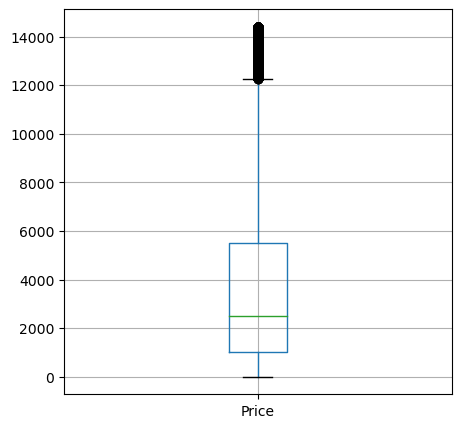

In [59]:
clean_data = quant('Price')
data['Price'].describe()

In [60]:
data = data.query('100<Price')

#### RegistrationYear

1985.5 2021.5


count    286411.000000
mean       2004.173359
std          75.030456
min        1000.000000
25%        1999.000000
50%        2003.000000
75%        2008.000000
max        9999.000000
Name: RegistrationYear, dtype: float64

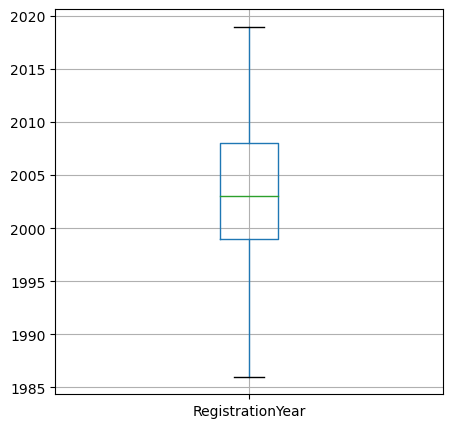

In [61]:
clean_data = quant('RegistrationYear')
data['RegistrationYear'].describe()

In [62]:
#число аномалий в исходном датасете
data[data['RegistrationYear']>=2022]['RegistrationYear'].count()

67

In [63]:
data[data['RegistrationYear']>=2022]['RegistrationYear']

15870     3200
17271     9999
17346     8888
18259     2200
20159     4100
          ... 
316079    5555
316487    5000
320452    8200
322234    5000
328453    2500
Name: RegistrationYear, Length: 67, dtype: int64

In [64]:
data = data[data['RegistrationYear']<2016]

#### Power

-42.0 254.0


count    266503.000000
mean        115.126809
std         196.461683
min           0.000000
25%          75.000000
50%         107.000000
75%         145.000000
max       20000.000000
Name: Power, dtype: float64

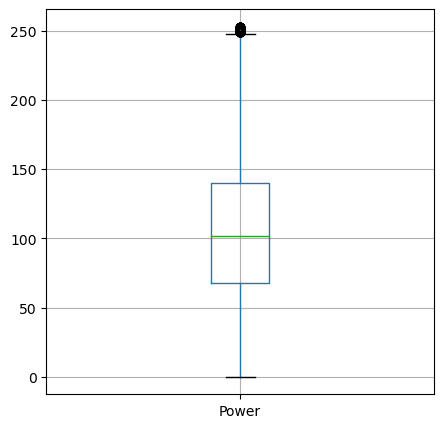

In [65]:
clean_data = quant('Power')
data['Power'].describe()

In [66]:
#число аномалий в исходном датасете
data[data['Power']>249]['Power'].count()

6885

In [67]:
data[data['Power']>620]['Power'].count()

292

In [68]:
data[data['Power']<13]['Power'].count()

24940

In [69]:
data = data.query('13<Power<252')

In [70]:
data[data['Power']>252]['Power'].count()

0

In [71]:
data[data['Power']<13]['Power'].count()

0

#### Kilometer

87500.0 187500.0


count    235330.000000
mean     126471.125653
std       37770.378150
min        5000.000000
25%      125000.000000
50%      150000.000000
75%      150000.000000
max      150000.000000
Name: Kilometer, dtype: float64

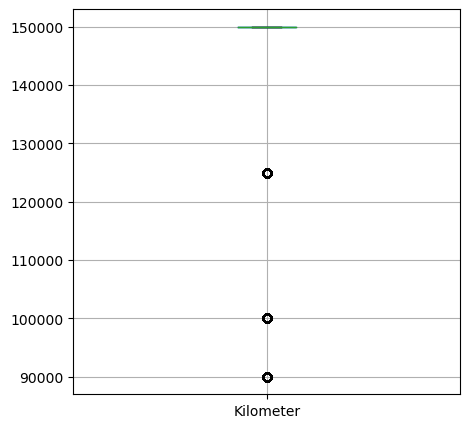

In [72]:
clean_data = quant('Kilometer')
data['Kilometer'].describe()

In [73]:
#число аномалий в исходном датасете
data[data['Kilometer']>150000]['Kilometer'].count()

0

#### NumberOfPictures

In [74]:
data

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired,NumberOfPictures
1,18300,coupe,2011,manual,190,uncpecified,125000,gasoline,audi,yes,0
2,9800,suv,2004,auto,163,grand,125000,gasoline,jeep,no,0
3,1500,small,2001,manual,75,golf,150000,petrol,volkswagen,no,0
4,3600,small,2008,manual,69,fabia,90000,gasoline,skoda,no,0
5,650,sedan,1995,manual,102,3er,150000,petrol,bmw,yes,0
...,...,...,...,...,...,...,...,...,...,...,...
354357,1690,wagon,2004,manual,55,fabia,150000,petrol,skoda,no,0
354362,3200,sedan,2004,manual,225,leon,150000,petrol,seat,yes,0
354366,1199,convertible,2000,auto,101,fortwo,125000,petrol,smart,no,0
354367,9200,bus,1996,manual,102,transporter,150000,gasoline,volkswagen,no,0


0.0 0.0


count    235330.0
mean          0.0
std           0.0
min           0.0
25%           0.0
50%           0.0
75%           0.0
max           0.0
Name: NumberOfPictures, dtype: float64

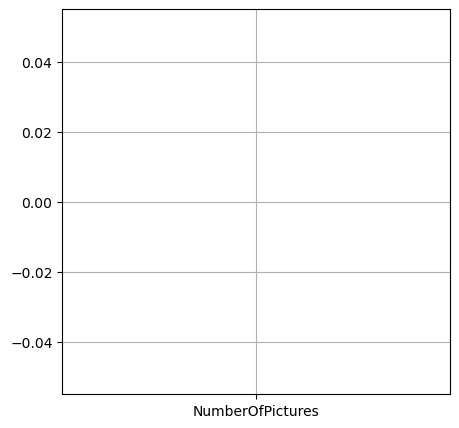

In [75]:
clean_data = quant('NumberOfPictures')
data['NumberOfPictures'].describe()

In [76]:
data['NumberOfPictures'].value_counts()

0    235330
Name: NumberOfPictures, dtype: int64

In [77]:
data = data.drop('NumberOfPictures', axis=1)

In [78]:
data.head()

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired
1,18300,coupe,2011,manual,190,uncpecified,125000,gasoline,audi,yes
2,9800,suv,2004,auto,163,grand,125000,gasoline,jeep,no
3,1500,small,2001,manual,75,golf,150000,petrol,volkswagen,no
4,3600,small,2008,manual,69,fabia,90000,gasoline,skoda,no
5,650,sedan,1995,manual,102,3er,150000,petrol,bmw,yes


In [79]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 235330 entries, 1 to 354368
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   Price             235330 non-null  int64 
 1   VehicleType       235330 non-null  object
 2   RegistrationYear  235330 non-null  int64 
 3   Gearbox           235330 non-null  object
 4   Power             235330 non-null  int64 
 5   Model             235330 non-null  object
 6   Kilometer         235330 non-null  int64 
 7   FuelType          235330 non-null  object
 8   Brand             235330 non-null  object
 9   Repaired          235330 non-null  object
dtypes: int64(4), object(6)
memory usage: 19.7+ MB


<div style="border:solid #81d8e6 2px; padding: 10px">
Мы удалили выбросы. 
    
    - максимальное число лошадиных сил - 620, а средняя мощность машин по миру составляет 212, в России 190, следовательно, мы можем доверять интервалу до 254 лс; важное уточнение, что самая маломощная машина имеет 13.5 лошадиных сил, поэтому снизу данные мы также ограничиваем.
    - сейчас 2023 год, поэтому все данные, год выпуска в которых больше 2023, можно удалить.
    - если во всём столбце NumberOfPictures одинаковые данные, то можно его удалить и отправить запрос разработчикам на проверку, потому что это скорее всего ошибка во время сбора данных.
</div>

### Проверка на мультиколлинеарность

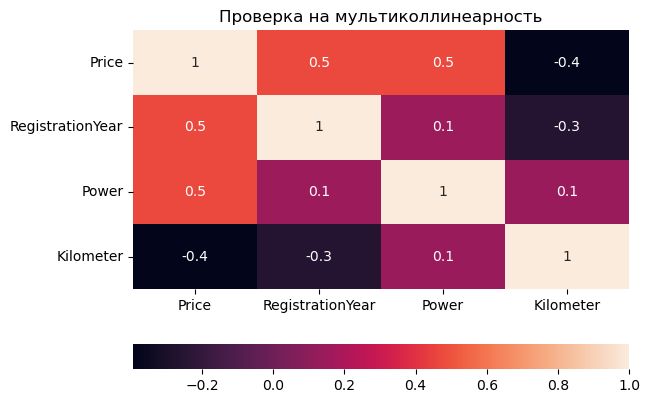

In [80]:
sns.heatmap(data.corr(), 
            annot = True, 
            fmt='.1g', 
            cbar_kws= {'orientation': 'horizontal'}).set_title('Проверка на мультиколлинеарность');

<div style="border:solid #81d8e6 2px; padding: 10px">
У нас нет сильно коррелирующих параметров.
</div>

### Вывод по предобработке данных

<div style="border:solid #81d8e6 2px; padding: 10px">
    
    - Мы удалили неинформативные или пустые столбцы
    - Мы провели работу с пропусками
    - Мы удалили дубликаты
    - Мы провели работу с типами столбцов
    - Мы провели работу с выбросами, на основании реальных данных и статистических закономерностей
    - Мы проверили параметры на мультиколлинеарность
</div>

## Обучение моделей

### Подготовка данных к обучению

#### Разделение выборок

In [81]:
features = data.drop('Price', axis=1)
target = data['Price']

features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size=0.25, random_state=RANDOM_STATE)


print(f"Количество строк в features_train: {features_train.shape[0]/data.shape[0]:1.2} выборки")
print(f"Количество строк в features_valid: {features_test.shape[0]/data.shape[0]:1.2} выборки")

Количество строк в features_train: 0.75 выборки
Количество строк в features_valid: 0.25 выборки


#### Масштабирование и кодирование

In [82]:
from sklearn.preprocessing import StandardScaler

In [83]:
data

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired
1,18300,coupe,2011,manual,190,uncpecified,125000,gasoline,audi,yes
2,9800,suv,2004,auto,163,grand,125000,gasoline,jeep,no
3,1500,small,2001,manual,75,golf,150000,petrol,volkswagen,no
4,3600,small,2008,manual,69,fabia,90000,gasoline,skoda,no
5,650,sedan,1995,manual,102,3er,150000,petrol,bmw,yes
...,...,...,...,...,...,...,...,...,...,...
354357,1690,wagon,2004,manual,55,fabia,150000,petrol,skoda,no
354362,3200,sedan,2004,manual,225,leon,150000,petrol,seat,yes
354366,1199,convertible,2000,auto,101,fortwo,125000,petrol,smart,no
354367,9200,bus,1996,manual,102,transporter,150000,gasoline,volkswagen,no


In [84]:
num_columns = ['RegistrationYear', 'Power']
cat_columns = ['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'Repaired', 'Kilometer']

transformer = ColumnTransformer(
    [("enc", OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1), cat_columns)],
    remainder='passthrough'
)

transformer_linear = ColumnTransformer(
            [("ohe", OneHotEncoder(handle_unknown = 'ignore', sparse=False, drop='first'), cat_columns),
            ("scaler", StandardScaler(), num_columns)],
            remainder='passthrough'
) 

<div style="border:solid #81d8e6 2px; padding: 10px">
Теперь в одних моделях обучения (форест и дерево, например) будем применять порядковое кодирование, а в линейной регрессии категориальные признаки будем кодировать, а числовые масштабировать.
</div>

### Обучение моделей

In [85]:
def fit_model(estimator, param_grid, X_train, y_train):
    model = GridSearchCV(estimator=estimator, 
                            param_grid=param_grid, 
                            n_jobs=-1, 
                            cv=4,
                            scoring='neg_root_mean_squared_error')

    model.fit(X_train, y_train)

    best_index = model.best_index_
    best_rmse = round(model.cv_results_['mean_test_score'][best_index], 1)

    print(f"Best RMSE: {abs(best_rmse)}")
    print(f"Best params: {model.best_params_}")

    return model.best_estimator_

<div style="border:solid #81d8e6 2px; padding: 10px">
Создаём функцию GridSearch
</div>

#### Лес решений

In [106]:
%%time

rf_estimator = Pipeline([
    ('transformer', transformer),
    ('rf', RandomForestRegressor(random_state=RANDOM_STATE, n_jobs=-1))
])

rf_param_grid =  {
    'rf__n_estimators': list(range(10, 80, 10)),
    "rf__max_depth": list(range(10, 40, 10)),
}

rf_best_model = fit_model(
    estimator=rf_estimator,
    param_grid=rf_param_grid,
    X_train=features_train,
    y_train=target_train
)

Best RMSE: 1630.3
Best params: {'rf__max_depth': 20, 'rf__n_estimators': 70}
Wall time: 3min 27s


#### LightGBM

In [91]:
features_train_lgbm = features_train.copy()
features_train_lgbm[cat_columns] = features_train_lgbm[cat_columns].astype("category")

In [110]:
%%time

lgbm_estimator = LGBMRegressor(random_state=RANDOM_STATE, n_jobs=-1)

lgbm_param_grid = {
    "n_estimators": range(300, 401, 10), 
    "max_depth": range(10, 21, 3),
    'learning_rate': [0.1, 0.2]
}

lgbm_best_model = fit_model(
    estimator=lgbm_estimator,
    param_grid=lgbm_param_grid,
    X_train=features_train_lgbm,
    y_train=target_train
)

Best RMSE: 1533.9
Best params: {'learning_rate': 0.1, 'max_depth': 16, 'n_estimators': 400}
Wall time: 2min 22s


#### CatBoost

In [107]:
%%time

catboost_estimator = CatBoostRegressor(random_state=RANDOM_STATE, verbose=False, cat_features=cat_columns)

catboost_param_grid = {
    "iterations": range(100, 201, 25),
    "learning_rate": [0.15, 0.25],
    "depth": range(3, 13, 3)
}

catboost_best_model = fit_model(
    estimator=catboost_estimator,
    param_grid=catboost_param_grid,
    X_train=features_train,
    y_train=target_train
)

Best RMSE: 1550.8
Best params: {'depth': 12, 'iterations': 200, 'learning_rate': 0.15}
Wall time: 9min 57s


(сократил выбор гиперпараметров, потому что на данный момент нет времени ждать так долго)

### Мини вывод

<div style="border:solid #81d8e6 2px; padding: 10px">
Все наши модели достигли нужного критерия: RMSE ниже 2500. Теперь можем приступить к анализу.
</div>

## Анализ моделей

### Рассмотрение качества моделей

#### Лес решений

In [111]:
features_train_transformed = transformer.fit_transform(features_train)

In [112]:
%%time
rf = RandomForestRegressor(
    n_estimators=70,
    max_depth=20,
    random_state=RANDOM_STATE,
    n_jobs=-1).fit(features_train_transformed, target_train)

Wall time: 2.86 s


In [113]:
%%time
rf.predict(features_train_transformed)

Wall time: 523 ms


array([15267.67261404,   971.18502405,  1191.98953829, ...,
       17082.52374501,  8233.19232048,   459.27687631])

#### LightGBM

In [114]:
%%time
lgbm = LGBMRegressor(
    learning_rate=0.1,
    max_depth=16,
    n_estimators=400,
    random_state=RANDOM_STATE,
    n_jobs=-1).fit(features_train_lgbm, target_train)

Wall time: 1.33 s


In [115]:
%%time
lgbm.predict(features_train_lgbm)

Wall time: 601 ms


array([13842.20312161,   965.11116312,  1163.52965249, ...,
       18119.97736249,  8391.31499243,   382.45620207])

#### CatBoost

In [116]:
%%time
cat = CatBoostRegressor(
    depth=12,
    iterations=200,
    learning_rate=0.15,
    random_state=RANDOM_STATE,
    cat_features=cat_columns,
    verbose=False).fit(features_train, target_train)

Wall time: 45.9 s


In [117]:
%%time
cat.predict(features_train)

Wall time: 661 ms


array([14311.96545242,   902.68799897,  1096.99157452, ...,
       17572.6556635 ,  8243.57787178,   449.27721652])

In [96]:
len(features_train_transformed)

176497

In [118]:
values = [[2.86, 0.523, 0.523/176633*1000000, 1630.3],
         [1.33, 0.601, 0.601/176633*1000000, 1533.9],
         [45.9, 1.05, 0.661/176633*1000000, 1550.8]]
table = pd.DataFrame(data=values, columns=['fit, s', 'predict, s', 'predicts one line, mcs', 'rmse'], index=['RandomForest', 'LGBM', 'CatBoost'])
display(table)

,"fit, s","predict, s","predicts one line, mcs",rmse
RandomForest,2.86,0.523,2.960942,1630.3
LGBM,1.33,0.601,3.402535,1533.9
CatBoost,45.90,1.050,3.742223,1550.8


###  Проверка на адекватность

In [119]:
max(target)

20000

In [120]:
random_prediction = [random.randint(0, 14499) for i in range(len(features_test))]
rmse = mean_squared_error(target_test, random_prediction) ** 0.5
print(f"RMSE на тестовой: {rmse:.1f}")

RMSE на тестовой: 6615.2


<div style="border:solid #81d8e6 2px; padding: 10px">
RMSE случайных предсказаний далеко от RMSE наших моделей: модели прошли проверку на адекватность.
</div>

### Вывод: лучшая модель

#### Самая качественная модель

In [121]:
%%time
features_test_lgbm = features_test.copy()
features_test_lgbm[cat_columns] = features_test_lgbm[cat_columns].astype("category")

rmse = mean_squared_error(target_test, lgbm.predict(features_test_lgbm)) ** 0.5
print(f"RMSE на тестовой: {rmse:.1f}")

RMSE на тестовой: 1539.8
Wall time: 351 ms


#### Самая быстрая модель

In [122]:
%%time
rmse = mean_squared_error(target_test, cat.predict(features_test)) ** 0.5
print(f"RMSE на тестовой: {rmse:.1f}")

RMSE на тестовой: 1546.8
Wall time: 311 ms


## Вывод

<div style="border:solid #81d8e6 2px; padding: 10px">
<b>Этап работы с данными</b>
Мы очистили данные, провели качественную предобработку:
    
    - удалили неинформативные столбцы
    - провели работу с пропусками
    - провели работу с дубликатами
    - провели работу с типами столбцов
    - провели работу с выбросами
    - проверили на мультиколлинеарность
    - адаптировали данные для моделей
    
<b>Этап работы с моделями</b> 
Мы выбрали для работы три модели:
    
    - Случайный лес решений
    - LightGBM
    - CatBoost
    
Каждая модель показала себя качественно во время проверки по RMSE. Однако выбраны были две:
    
    - Если заказчику важнее качество модели, то лучше передать модель LightGBM
    - Если заказчику важнее скорость модели, то лучше передать модель CatBoost
    
Разница незначительная, поэтому можно использовать две модели:
    
    
    
</div>

In [123]:
lgbm = LGBMRegressor(
    learning_rate=0.1,
    max_depth=16,
    n_estimators=400,
    random_state=RANDOM_STATE,
    n_jobs=-1)

In [124]:
cat_columns = ['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'Repaired', 'Kilometer']
cat = CatBoostRegressor(
    depth=12,
    iterations=200,
    learning_rate=0.15,
    random_state=RANDOM_STATE,
    cat_features=cat_columns,
    verbose=False)